In [85]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

In [86]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=.2),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor()
])

train_data = datasets.CIFAR10(root = '../Data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root = '../Data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [87]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.2)
               RandomRotation(degrees=(-30, 30), resample=False, expand=False)
               ToTensor()
           )

In [88]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.2)
               RandomRotation(degrees=(-30, 30), resample=False, expand=False)
               ToTensor()
           )

In [89]:
torch.manual_seed(0)

train_loader = DataLoader(train_data, batch_size=10, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False, pin_memory=True)

In [90]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

tensor([4, 3, 8, 1, 1, 7, 3, 7, 0, 2])

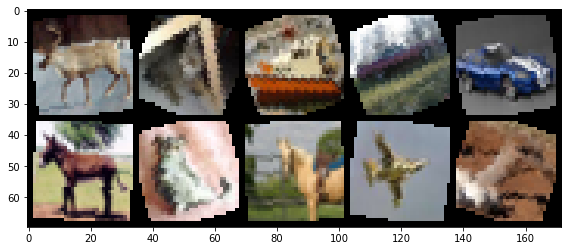

In [91]:
for images, labels in train_loader:
    break

im = make_grid(images, nrow=5)
plt.figure(figsize=(10, 4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
labels

In [92]:
images.size()

torch.Size([10, 3, 32, 32])

In [93]:
class ConvModel1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers1 = nn.Sequential(
            nn.Conv2d(3, 32, 3,padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3,padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32,64,3,padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64,64,3,padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64,128, 3,padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128,128, 3,padding=1),
            nn.ReLU(inplace=True),
            #nn.BatchNorm2d(128),
            nn.MaxPool2d(2)
        )
        self.layers2 = nn.Sequential(
            nn.Dropout(p=.2, inplace=True),
            nn.Linear(4*4*128, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 10)
        )
        
    def forward(self, X):
        X = self.layers1(X)
        X = torch.flatten(X, 1)
        X = self.layers2(X)
        X = F.log_softmax(X, dim=1)
        return X

In [94]:
torch.manual_seed(0)
model = ConvModel1()
model.cuda()
model

ConvModel1(
  (layers1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128

In [95]:
for item in model.parameters():
    print(item.numel())

864
32
32
32
9216
32
32
32
18432
64
64
64
36864
64
64
64
73728
128
128
128
147456
128
2097152
1024
10240
10


In [96]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

In [97]:
import time
start_time = time.time()
epochs = 50
train_losses = []
test_losses = []

train_correct = []
test_correct = []
best_accuracy = 0
early_stopping = 0

for e in range(epochs):
    epoch_time = time.time()
    trn_cor = 0
    tst_cor = 0
    batch_loss = 0
    model.train()
    for batch, (X_train, y_train) in enumerate(train_loader):
        
        X_train = X_train.cuda()
        y_train = y_train.cuda()
        
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        
        predicted = torch.max(y_pred.data,1)[1]
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_cor = (predicted==y_train).sum()
        trn_cor += batch_cor
        batch_loss += loss
    
    batch_loss = batch_loss/(50000/10)
    train_losses.append(batch_loss)
    train_correct.append(trn_cor)
    
    model.eval()
    batch_tst_loss=0
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            
            X_test = X_test.cuda()
            y_test = y_test.cuda()
            
            y_val = model(X_test)
            predicted = torch.max(y_val.data,1)[1]
            
            batch_cor = (predicted==y_test).sum()
            tst_cor += batch_cor
            
            tst_loss = criterion(y_val, y_test)
            batch_tst_loss += tst_loss
            
        batch_tst_loss = batch_tst_loss / (10000/10)
        test_losses.append(batch_tst_loss)
        test_correct.append(tst_cor)
    test_accuracy = tst_cor.item()*100/10000
    print(f'Epoch: {e+1} Loss: {batch_loss.item():10.4f} Accuracy: {trn_cor.item()*100/50000:7.2f}% Val-loss: {batch_tst_loss.item():10.4f} Val-accuracy: {test_accuracy:7.2f}% Epoch time: {time.time() - epoch_time}')
    
    if test_accuracy > best_accuracy:
        torch.save(model.state_dict(), 'best_cnn.pt')
        best_accuracy = test_accuracy
        early_stopping = 0
        
    else:
        early_stopping +=1
    if early_stopping >= 10:
        print(f'Early stopping after {e+1} epochs')
        break
print(f'Duration of training: {(time.time() - start_time)/60:.2f} minutes.')

Epoch: 1 Loss:     1.4893 Accuracy:   46.02% Val-loss:     1.2259 Val-accuracy:   55.97% Epoch time: 102.87147116661072
Epoch: 2 Loss:     1.1508 Accuracy:   59.49% Val-loss:     1.0283 Val-accuracy:   64.28% Epoch time: 104.41827058792114
Epoch: 3 Loss:     1.0238 Accuracy:   64.40% Val-loss:     0.9541 Val-accuracy:   67.23% Epoch time: 101.15958404541016
Epoch: 4 Loss:     0.9365 Accuracy:   67.57% Val-loss:     0.9069 Val-accuracy:   69.00% Epoch time: 101.9071319103241
Epoch: 5 Loss:     0.8794 Accuracy:   69.58% Val-loss:     0.8245 Val-accuracy:   71.49% Epoch time: 104.96043753623962
Epoch: 6 Loss:     0.8325 Accuracy:   71.41% Val-loss:     0.7899 Val-accuracy:   72.80% Epoch time: 101.59745907783508
Epoch: 7 Loss:     0.7844 Accuracy:   72.90% Val-loss:     0.7692 Val-accuracy:   73.87% Epoch time: 105.89412641525269
Epoch: 8 Loss:     0.7575 Accuracy:   73.89% Val-loss:     0.7685 Val-accuracy:   74.46% Epoch time: 105.8765504360199
Epoch: 9 Loss:     0.7269 Accuracy:   75.0

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(20,4))
plt.plot(train_losses, label='Train loss')
plt.plot(test_losses, label='Test loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Crossentropy Loss')

In [ ]:
plt.figure(figsize=(20,4))
plt.plot([t*100/50000 for t in train_correct], label='Train Accuracy')
plt.plot([t*100/10000 for t in test_correct], label='Test Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')